In [20]:
%load_ext autoreload
%autoreload 2

In [1]:
filepath = r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\PBSIM-PacBio-Simulator"

In [2]:
!cd "C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\PBSIM-PacBio-Simulator"

In [9]:

import os
from utils import get_reference_from_file, read_strands_from_file, read_strands_from_file_alt

sequenced_strands = {}
collected_files = set()

for file in os.listdir(filepath):
    if file[:2] == "sd":
        
        filename = file[:7]

        if filename in collected_files:
            continue

        collected_files.add(filename)

        ref_file = os.path.join(filepath, filename + ".ref")
        fastq_file = os.path.join(filepath, filename + ".fastq")

        ref = get_reference_from_file(ref_file)
        strands = read_strands_from_file_alt(fastq_file)
        sequenced_strands[ref] = strands
        print(f"Collected {ref}")
            

Collected 3823f37c-5239-4e40-b79a-8caa179b47c3
Collected 690ce148-f0f9-4fc9-9922-7cc16baaea4b
Collected 517665dd-57a1-4d11-9541-bc974c35f26a
Collected a7edd81c-9a09-4b79-80f2-2130d743e826
Collected e8586e97-2d2a-4f41-aca7-35c01751a34b
Collected 1fde53d1-385d-480c-bb71-1f3d5f2c9134
Collected 65a564b4-d90c-4951-9597-10f959945fd1
Collected b415ef82-22f4-4766-a72c-5e7bd4e02067
Collected 40879282-30a5-4d49-a576-efe8e7ac9b4a
Collected 8608e1a7-e85e-4b14-88fa-f42d49c700e5
Collected 9effc92e-7a87-4dfe-a733-c0aafdf0e4de
Collected 9caea68c-1585-4014-8e2b-a33a56021eea
Collected a97ba880-e506-4568-a90d-e2709740482a
Collected 6e83438f-d9b5-4110-90dc-e2aa6d793c57
Collected 47d364f5-b3bf-40a4-ab69-54e778720509
Collected eeac40a1-8706-43f0-9032-07e4f92ef358
Collected 9f137acd-4442-4b91-a7bb-db7bc61f3f17
Collected aac59dd2-f3e1-4169-9979-aae00d5bf408
Collected e95da740-9e9c-4aa8-ac20-7cc2186d1262
Collected 93490b4b-cd1a-4923-aa41-200d4ed30599
Collected 4744206d-4960-4510-8159-38a6ebd97fe0
Collected 71d

In [ ]:
from creating_synthesized_strands_from_strands import get_original_strands
from sequencing import NaiveSequencingModel
import time
from tqdm.notebook import tqdm
from utils import get_recovery_percentage
from seq_stat import cluster_seq


ids, coupling_rates, capping_flags, original_strands = get_original_strands()
recovery_percentages = []

for label, coupling_rate, capping_flag, original_strand in (zip(ids, coupling_rates, capping_flags, original_strands)):
    
    print(f"{label} {coupling_rate} {capping_flag}")
    sequenced_strand_repeats = sequenced_strands[label]
    
    startime = time.time()

    # Testing the clustering
    consensus_strand = cluster_seq(
        sequenced_strand_repeats, reference_sequence=original_strand, n_clusters=5)
    

    #sequencing_model = NaiveSequencingModel(strand_length=len(original_strand))
    #consensus_strand = sequencing_model.consensus_decoding(sequenced_strand_repeats, original_strand, alignment=False)
    #endtime = time.time()
    recovery_percentage = get_recovery_percentage(consensus_strand, original_strand)
    
    print(recovery_percentage)
    recovery_percentages.append(recovery_percentage)
    


3823f37c-5239-4e40-b79a-8caa179b47c3 8 True


In [11]:
coupling_rates = [float(i) for i in coupling_rates]

In [12]:
capping_flags = [eval(i) for i in capping_flags]

In [13]:

recovery_rates_capping = {i:[] for i in list(set(coupling_rates))}
recovery_rates_no_capping = {i:[] for i in list(set(coupling_rates))}

for recovery, coupling_rate, capping_flag in zip(recovery_percentages, coupling_rates, capping_flags):
    if capping_flag:
        recovery_rates_capping[coupling_rate].append(recovery)
    
    else:
        recovery_rates_no_capping[coupling_rate].append(recovery)

In [14]:
import numpy as np

recovery_rates_capping_means = {i : np.mean(recovery_rates_capping[i]) for i in recovery_rates_capping.keys()}

recovery_rates_no_capping_means = {i : np.mean(recovery_rates_no_capping[i]) for i in recovery_rates_no_capping.keys()}

In [15]:
recovery_rates_capping_means

{8.0: 0.31004636381506673,
 8.25: 0.30964364153629814,
 9.0: 0.3204638100838018,
 8.5: 0.3301402946108236,
 8.75: 0.31395886542043044,
 9.25: 0.3051642270132259,
 9.5: 0.32385811067709874,
 9.75: 0.3255636998567528,
 9.99: 0.31349452928096433}

In [16]:
print("Recovery rates for capping with different coupling rates")
for key, value in recovery_rates_capping_means.items():
    print(f"{key}: {value:.2f}\n")

print("\nRecovery rates for no capping with different coupling rates")
for key, value in recovery_rates_no_capping_means.items():
    print(f"{key}: {value:.2f}\n")

Recovery rates for capping with different coupling rates
8.0: 0.31

8.25: 0.31

9.0: 0.32

8.5: 0.33

8.75: 0.31

9.25: 0.31

9.5: 0.32

9.75: 0.33

9.99: 0.31


Recovery rates for no capping with different coupling rates
8.0: 0.31

8.25: 0.32

9.0: 0.31

8.5: 0.30

8.75: 0.32

9.25: 0.33

9.5: 0.32

9.75: 0.31

9.99: 0.31



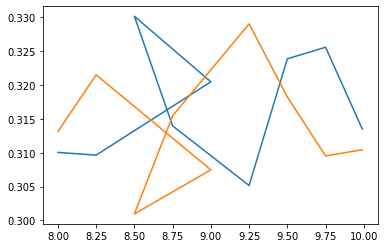

In [17]:

import matplotlib.pyplot as plt

coupling_rates_unique = list(set(coupling_rates))
plt.plot(coupling_rates_unique, recovery_rates_capping_means.values())
plt.plot(coupling_rates_unique, recovery_rates_no_capping_means.values())

plt.show()

(array([152.,   0.,   0.,   0.,   0.,  89., 326., 203., 309., 525.]),
 array([  1. ,  18.1,  35.2,  52.3,  69.4,  86.5, 103.6, 120.7, 137.8,
        154.9, 172. ]),
 <BarContainer object of 10 artists>)

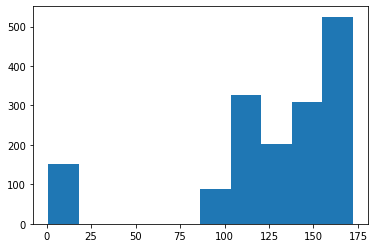

In [115]:
lens = [len(i) for i in sequenced_strand_repeats]
import matplotlib.pyplot as plt

plt.hist(lens)

In [61]:
print(consensus_strand)

CTGTCCATCTAGTTCCGGTCCCAAGAGATACGGAGACAAGAAAAACCAACTCCCAGATGTTACGCAGGGCAAAGTATATTAATTCACGTCTCATGCTCGTGTGGAGCTTTGGCGCTTGTCCCGTGTCTACGATCAGAAATGTTTGGCGCGTGGGTTACTAGGCTCGGATAAGGAAAACACCAATCTTCATCAGTGACAGC


In [62]:
print(original_strand)

CTGTCCATCTAGTTCCGGTCCCAAGAGATACGGAGACAAGAAAAACCAACTCCCAGATGTTACGCAGGGCAAAGTATATTAATTCACGTCTCATGCTCGTGTGGAGCTTTGGCGCTTGTCCCGTGTCTACGATCAGAAATGTTTGGCGCGTGGGTTACTAGGCTCGGATAAGGAAAACACCAATCTTCATCAGTGACAGC


In [63]:
from main import get_recovery_percentage

get_recovery_percentage(consensus_strand, original_strand)

1.0

In [47]:
original_strands

['CTGTCCATCTAGTTCCGGTCCCAAGAGATACGGAGACAAGAAAAACCAACTCCCAGATGTTACGCAGGGCAAAGTATATTAATTCACGTCTCATGCTCGTGTGGAGCTTTGGCGCTTGTCCCGTGTCTACGATCAGAAATGTTTGGCGCGTGGGTTACTAGGCTCGGATAAGGAAAACACCAATCTTCATCAGTGACAGC',
 'GTTCAAATTGCAACCCGGTAAAGACTGCTGGCTAACAATAAGGACACATACATGCTCCGAACGTCCCGTTTATGTCCACGAAAGGGCTGCGTTTAGACTAAGCGGTTCTGTACCCGTCTCATCCTCACGGGCGCGCTTGGGATCACTGTTTGACCTGACAGTTACGCACTAACGTGACTGGTCAATCCCTAATAGTCAGA',
 'TATTTTACTTTGTGAGTTCACATCATCCATTGCGGCGCGACGTAGGAAATCGATGATATTCAACGCCAACTCGCCCTTATACCCCCTACGGCCCATGCGTCTTTAAGATTCTGCTTTGGACGCAGGAAACTTTTTAGAATCTTCACCGAGCCGGTTAGCTTGCACACTTTCCCACGTGATGACGCTACTCGTTCTTATCA',
 'CTCACGATAATTTACTTAGGAATTGTCACCGGTCCGGAGACCCACTAAATGTTTTTAGCGGGGGCACCCACTGTCCGACTACCGCACGTTACTGGCGTAAACACCGGGGTCGCTGCCGGATCGAATCATCTTTAAAAGCCTATACGGACCTTATATGCGTGGGCACGGCAAGGCGCGTTACTTCATGGGCGTACCCCCCC',
 'AAGCTTTGTTCATAGCCCACCCCCCCCGTTATCGATGTCCTAAGTACGAGAGAGTGGGGAGGAATAAGTGCGAGCATCCAATTTCAGAAAGGACCTGCAGTTCAGCGTAGACACACGCGATGAAAAATCACGCTGAGTTCGTTCTACATCCGGGTCCAAAAAACGGTGGGTGCGCCAT

In [14]:
os.listdir()

['.ipynb_checkpoints',
 'creating_synthesis_file.py',
 'creating_synthesized_strands_from_strands.py',
 'dna_storage.py',
 'ecc.py',
 'getting_files.ipynb',
 'main.py',
 'original_strands.txt',
 'reads.txt',
 'sd_0003.fastq',
 'sd_0003.ref',
 'sd_0044.fastq',
 'sd_0044.maf',
 'sd_0044.ref',
 'sequenced_badread.txt',
 'sequencing.py',
 'seq_stat.py',
 'synthesis.py',
 'synthesized.fasta',
 'synthesized_strands.fasta',
 'synthesized_strands.txt',
 'synthesized_strands_2.fasta',
 'utils.py',
 '__pycache__']